<a href="https://colab.research.google.com/github/mdmake/intro-to-dl-hse/blob/2021-2022/training/seminars_04_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mmakemd","key":"a086f54189fb149edae07fd380042089"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%bash
kaggle datasets download -d lantian773030/pokemonclassification
unzip -qq pokemonclassification.zip

100%|██████████| 417M/417M [00:05<00:00, 73.4MB/s]


In [ ]:
!ls -la PokemonData

total 608
drwxr-xr-x 152 root root 4096 Jan 15 08:41  .
drwxr-xr-x   1 root root 4096 Jan 15 08:41  ..
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Abra
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Aerodactyl
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Alakazam
drwxr-xr-x   2 root root 4096 Jan 15 08:41 'Alolan Sandslash'
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Arbok
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Arcanine
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Articuno
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Beedrill
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Bellsprout
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Blastoise
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Bulbasaur
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Butterfree
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Caterpie
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Chansey
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Charizard
drwxr-xr-x   2 root root 4096 Jan 15 08:41  Charmander
drwxr-xr-x   2 root root 4096 Jan 15 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision.datasets import MNIST, SVHN
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [ ]:
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [71]:
class PockemonDataset(Dataset):

  SPLIT_RANDOM_SEED = 42
  TEST_SIZE = 0.25



  def __init__(self, root, train=True, load_to_ram=True, transform=None):
      super().__init__()
      self.root = root
      self.train = train
      self.load_to_ram = load_to_ram
      self.transform = transform
      self.classes = sorted(os.listdir(self.root))
      self.all_files = []
      self.all_labels = []
      self.images = []

      for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
        files = sorted(os.listdir(os.path.join(self.root, class_name)))
        train_files, test_files = train_test_split(files,
                                                   random_state=self.SPLIT_RANDOM_SEED + i,
                                                   test_size=self.TEST_SIZE
                                                   )
        if self.train:
          self.all_files += train_files
          self.all_labels+=[i]*len(train_files)
          if self.load_to_ram:
            self.images += self._load_image(train_files, i)


        else:
          self.all_files += test_files
          self.all_labels+=[i]*len(test_files)
          if self.load_to_ram:
            self.images += self._load_image(test_files, i)


  def _load_image(self,image_files, label):
    images = []
    for filename in image_files:
      image = Image.open(os.path.join(self.root, self.classes[label], filename))
      images += [image,]

    return images




  def __len__(self):
      return len(self.all_files)

  def __getitem__(self, item):

      label = self.all_labels[item]

      if self.load_to_ram:
        image = self.image[item]
      else:
        filename = self.all_files[item]
        image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

      if self.transform:
        image = self.transform(image)

      return image, label



In [ ]:
import glob

bad_images = glob.glob('PokemonData/*/*.svg')

bad_images

['PokemonData/Venomoth/bb5d47bced6e4e33a77faa17e1eec906.svg',
 'PokemonData/Magneton/45e434d002bd44eeb1acbc2decc8ee0f.svg',
 'PokemonData/Scyther/a8734f10941a4deb95fcf7388e4fe8e2.svg',
 'PokemonData/Golduck/bc08a691e7cb41b0bec2adf931dc9634.svg',
 'PokemonData/Dewgong/e3ecbb47e192470aa8686734b7813b43.svg',
 'PokemonData/Exeggutor/f29b4f9fccff4055b167ece6556143cd.svg',
 'PokemonData/Exeggutor/2b8bc491c5ca4e788999f8ea53617638.svg',
 'PokemonData/Tentacruel/d6fb0a3046364ea2b49525c6f6b966e5.svg',
 'PokemonData/Omastar/1be6e7da1bba4379b298b20013c57b4b.svg',
 'PokemonData/Zapdos/c99b2d19544c4cbbacd7711ade660279.svg',
 'PokemonData/Cloyster/ff270ebfab0f46b3b05c3fecd6a15ef9.svg',
 'PokemonData/Graveler/3fe3c6a0bbd14de89092d2c675f743c1.svg']

In [ ]:
for bad_image in bad_images:
  os.remove(bad_image)

In [62]:
train_dataset = PockemonDataset(root='PokemonData', train=True, load_to_ram=False)

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
image, label = train_dataset[100]

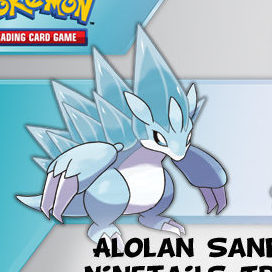

In [ ]:
image

In [ ]:
train_dataset.classes[label]

'Alolan Sandslash'

In [ ]:
len(train_dataset)

5063

In [63]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [72]:
train_dataset = PockemonDataset(root='PokemonData', train=True, load_to_ram=False, transform=train_transform)
test_dataset = PockemonDataset(root='PokemonData', train=False, load_to_ram=False, transform=train_transform)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [73]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [74]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

num_epochs = 10
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [75]:
# model

In [76]:
sum(param.numel() for param in model.parameters())

2416022

In [ ]:
%%time
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

Training 1/10:   0%|          | 0/159 [00:00<?, ?it/s]